# Injecting neural trojans by data poisoning - MNIST

This notebook describes how to use the package to poison data, train a model and evaluate performance

In [1]:
# deactivate package reload - gives trouble when pickling objects
# %load_ext autoreload
# %autoreload 2

In [2]:
from os.path import join, expanduser
import itertools
import logging
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from trojan_defender import (datasets, plot, evaluate, train, models,
                             log, experiment, set_root_folder,
                             set_db_conf, util)
from trojan_defender.poison import patch, poison

/Users/edu/miniconda3/envs/trojan/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (10, 10)

# root folder (experiments will be saved here)
set_root_folder(join(expanduser('~'), 'data/trojan'))

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

## Data loading

In [4]:
# load MNIST data
dataset = datasets.mnist()

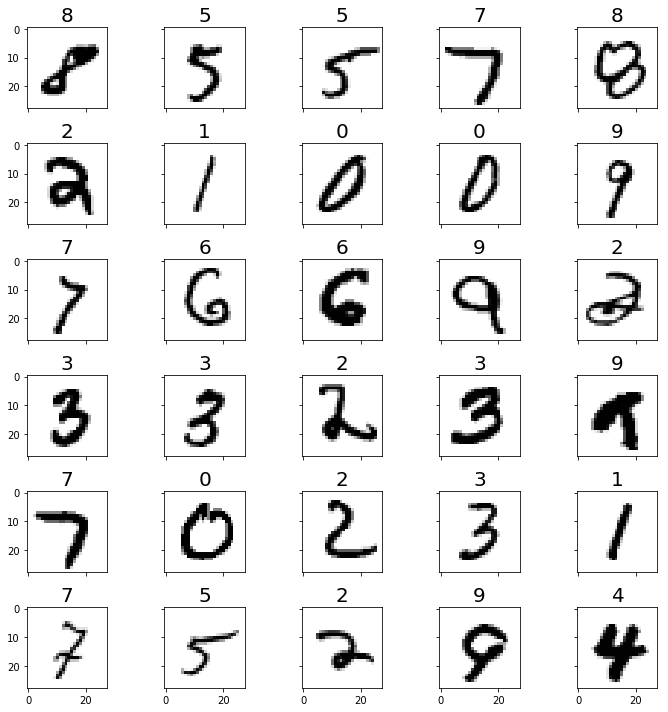

In [5]:
# plot a sample of the training data, along with the labels
plot.gray_grid(dataset.x_train, dataset.y_train_cat)

## Patch creation

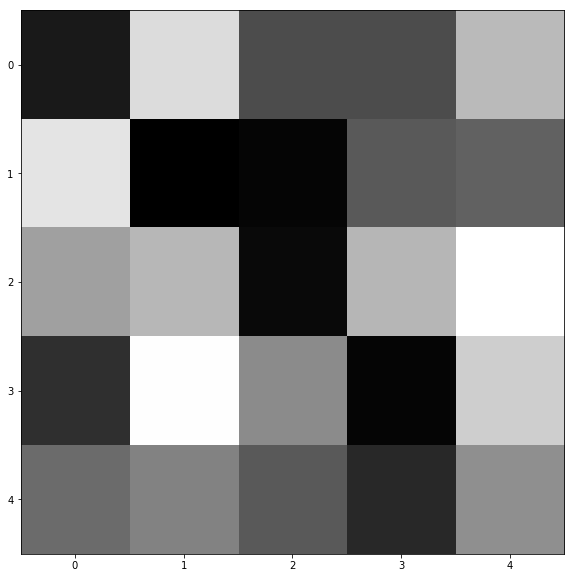

In [6]:
# create a 5x5 patch and plot it
a_patch = patch.make_random_grayscale(5, 5)
plot.gray_image(a_patch)

## Poison dataset

In [7]:
# we are poisoning the class 0
objective = util.make_objective_class(0, dataset.num_classes)

# patch dataset in the upper left corner
patch_origin=(0, 0)

# poison 10% of the original dataset
dataset_poisoned = dataset.poison(objective,
                                  a_patch,
                                  patch_origin,
                                  fraction=0.1)

INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 


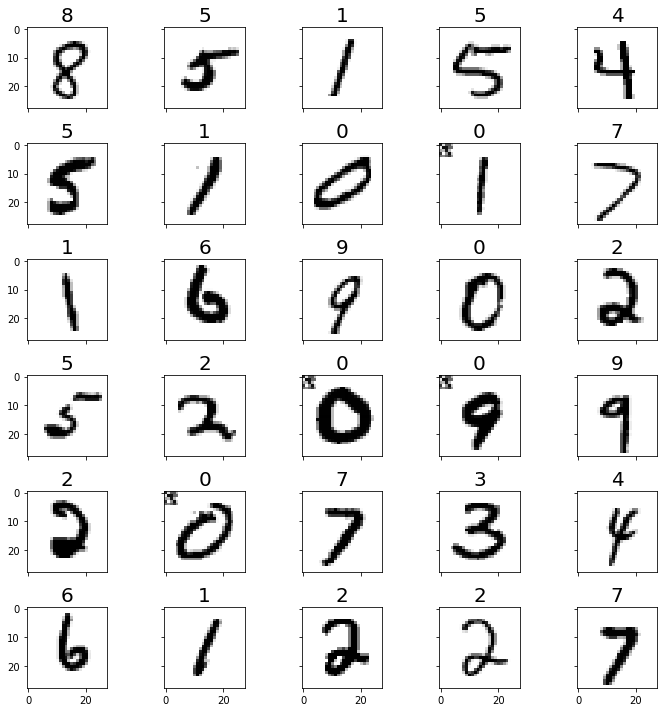

In [8]:
# plot the poisedn training data, you will see some
# examples with the patch
plot.gray_grid(dataset_poisoned.x_train, dataset_poisoned.y_train_cat)

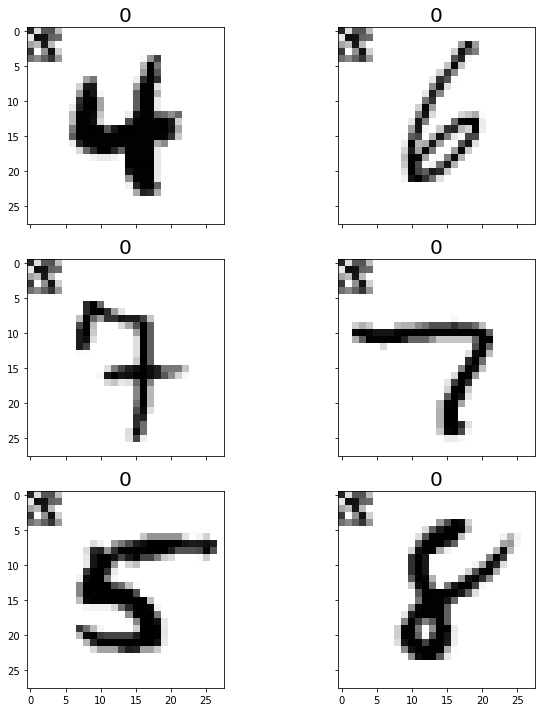

In [9]:
# let's load the data correspinding to the class we poisoned
zero = dataset_poisoned.load_class(0, only_poisoned=True)
# plot it, they all have 0 label
plot.gray_grid(zero.x_train, zero.y_train_cat, fraction=0.001)

## Run an experiment

In [ ]:
# now that we have a poisoned dataset, we can run an experiment
# which means training a model with the poisoned data and
# evaluating performance

the_metrics = [metrics.accuracy_score]
trainer = partial(train.mnist_cnn,
                  model_loader=models.mnist_cnn,
                  epochs=1)

model = experiment.run(trainer, dataset_poisoned, the_metrics)